# Proyecto Imágenes Laboratorio Inteligencia

### Profesor: Claudio Pérez
### Auxiliar: Juan Pérez
### Integrantes: Matías Osses - Ignacio - Alejandro

El objetivo de este proyecto final es desarrollar e implementar un algoritmo de búsqueda de imágenes similares basado en su contenido (Content Based Image Retrieval, CBIR) utilizando distintos métodos de extracción de características. Para el desarrollo de este proyecto debe descargar la base de datos INRIA Holidays dataset. Debe descargar los archivos jpg1.tar.gz y jpg2.tar.gz que contienen imágenes de consulta para 500 clases distintas y las imágenes que deberán ser almacenadas en el buscador, y que están asociadas a esas 500 clases. La figura 1 muestra las principales etapas de un sistema CBIR.


## Importación de librerías

In [2]:
import os
import copy
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize


## Cálculo de vector de características

In [3]:
class Imagen():
    
    def __init__(self, path):
        self.nombre = path.split('\\')[-1]
        self.img = cv2.imread(path)
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2HSV)
        #self.img = cv2.resize(self.img, (3264,2448))
        self.histogramas = dict()
        self.asd = dict()
        
    def division(self, n=3):
        nombre = '%sx%s'%(n,n)
        rows, cols, depth = self.img.shape
        histH = []
        histS = []
        histV = []
        div_y = np.linspace(0, rows, n+1).astype(int)
        div_x = np.linspace(0, cols, n+1).astype(int)
        for i, y in enumerate(div_y[1:]):
            for j, x in enumerate(div_x[1:]):
                celda = self.img[div_y[i]:div_y[i]+y, div_x[i]:div_x[i]+x, 0]
                histH.append(np.histogram(celda, bins=8, density = True)[0])
                celda = self.img[div_y[i]:div_y[i]+y, div_x[i]:div_x[i]+x, 1]
                histS.append(np.histogram(celda, bins=12, density = True)[0])
                celda = self.img[div_y[i]:div_y[i]+y, div_x[i]:div_x[i]+x, 2]
                histV.append(np.histogram(celda, bins=3, density = True)[0]) 
                
        self.histogramas[nombre+'_H'] = np.array(histH)
        self.histogramas[nombre+'_S'] = np.array(histS)
        self.histogramas[nombre+'_V'] = np.array(histV)
    
    def divisionNoRectangular(self):
        heigth, width, _ = self.img.shape
        center = (int(width/2), int(heigth/2))
        axis = (int(width/2*0.8), int(heigth/2*0.8))

        #elipse central
        container = np.zeros((heigth,width))
        r1 = (cv2.ellipse(container, center, axis, 0,0, 360, (255,255,255),-1)/255).astype(int)
        #esquina superior izquierda
        container = (container*0).astype(int)
        r2 = (r1 == 0).astype(int) * cv2.rectangle(container, (0,0), center, (255,255,255), -1)
        #esquina superior derecha
        container = (container*0).astype(int)
        r3 = (r1 == 0).astype(int) * cv2.rectangle(container, (int(width/2),0), (width, int(heigth/2) ), (255,255,255), -1)
        #esquina inferior izquierda
        container = (container*0).astype(int)
        r4 = (r1 == 0).astype(int) *  cv2.rectangle(container, (0,int(heigth/2)), (int(width/2), heigth ), (255,255,255), -1)
        #esquina inferior derecha
        container = (container*0).astype(int)
        r5 = (r1 == 0).astype(int) *  cv2.rectangle(container, center, (width,heigth), (255,255,255), -1)    
       
        
        canal = ['H', 'S', 'V']
        bins = [8, 12, 3]
        
        for (n,c,b) in zip(range(3),canal,bins):
            v1 = self.img[:,:,n][r1 > 0]
            v2 = self.img[:,:,n][r2 > 0]
            v3 = self.img[:,:,n][r3 > 0]
            v4 = self.img[:,:,n][r4 > 0]
            v5 = self.img[:,:,n][r5 > 0]
            self.histogramas['reg1_'+c] = np.histogram(v1, bins=b, density = True)[0]
            self.histogramas['reg2_'+c] = np.histogram(v2, bins=b, density = True)[0]
            self.histogramas['reg3_'+c] = np.histogram(v3, bins=b, density = True)[0]
            self.histogramas['reg4_'+c] = np.histogram(v4, bins=b, density = True)[0]
            self.histogramas['reg5_'+c] = np.histogram(v5, bins=b, density = True)[0]
    

    
    def calcularVectorCaracteristicas(self):
        self.division(3)
        self.division(4)
        self.division(6)
        self.divisionNoRectangular()
        
        h = np.array([],dtype=int)
        for key in self.histogramas.keys():
            h = np.concatenate([h,self.histogramas[key].reshape(-1)])
        return h

## Distancias

In [4]:
def euclidiana(x,y):
    return np.sqrt(np.sum(x**2+y**2))

def coseno(x,y): 
    num = np.dot(x,y)
    den = np.sqrt((x**2).sum())*np.sqrt((y**2).sum())
    return num/den

def chi_cuadrado(x,y):
    x_t = x.sum()
    y_t = y.sum()
    c = x + y
    x_esperado = x_t*c/(x_t+y_t)
    y_esperado = y_t*c/(x_t+y_t)
    
    return (((x-x_esperado)**2)/x_esperado).sum() + (((y-y_esperado)**2)/y_esperado).sum()
    
def cramer(x,y):
    return(np.sqrt(chi_cuadrado(x,y)/(x.sum() + y.sum())))

## Content Based Image Retrieval (CBIR)

In [5]:

class CBIR():
    
    def __init__(self, distance):
        self.distance = distance
        self.database = list()
        self.scores = []
        #self.scores = list()
    def train(self,X):
        for image in X:
            self.database.append(Imagen(image).calcularVectorCaracteristicas())
    def evaluar(self,Input):
        #scores = []
        inc = Imagen(Input).calcularVectorCaracteristicas()
        for x in self.database:
            self.scores.append(self.distance(inc, x))
        
        #scores = [self.distance(Input, x) for x in self.database]

In [7]:
pathj=r'C:\Users\aleja\Desktop\ImagPLIC\jpg1'
a = cv2.imread(pathj+'\\100000.jpg')

In [8]:
c=[] 
for filename in os.listdir(pathj):
    c.append(os.path.join(pathj,filename))

In [86]:
fi=CBIR(coseno)


In [87]:
rr=fi.train(c[:100])

In [88]:
fi.evaluar(c[0])

In [89]:
fi.scores

[0.9999999999999994,
 0.11023959970867489,
 0.1495802529368512,
 0.12193257413576199,
 0.1530884098827887,
 0.0357337211832651,
 0.04411943480026082,
 0.23778557758749874,
 0.06664184420040453,
 0.046625193885230565,
 0.1565585552266783,
 0.060556049937014404,
 0.6109574617813827,
 0.12268925773904288,
 0.28178857199800095,
 0.10726381621397606,
 0.013898458591982746,
 0.01985679854949207,
 0.034929322109042676,
 0.05591921762026603,
 0.14701937111984048,
 0.3367419404139653,
 0.07184739238110223,
 0.252475677336547,
 0.11699988610125901,
 0.016594710218598437,
 0.018091951307240114,
 0.04338090372647291,
 0.06022568849454449,
 0.04158873652954261,
 0.05916036033027021,
 0.24004835040267214,
 0.2756779237625202,
 0.03345228313903821,
 0.29390037452607287,
 0.16325897479270973,
 0.17203267469206374,
 0.17547729078899432,
 0.22125372047532613,
 0.15953869134220947,
 0.12741297790631106,
 0.09592336274883649,
 0.13352555372032657,
 0.06567216114506604,
 0.08532938961241807,
 0.13526050349

In [90]:
def calculaRanking(diffarray, database, img_num):#diffarray:son los scores, image: es el path de la imagen, ranktype tipo de ranking
    image=database[img_num]
    path=image[:len(image)-5]
    image_n=image[len(image)-5:len(image)-4]
    same_class=[]
    N=-1 #son todas las adicionales a su clase excluyendo la examinada
    menores=0
    mayores=0
    for i in range(10):
        if os.path.isfile(path+str(i)+'.jpg') == True:
            same_class.append(path+str(i)+'.jpg')
            N += 1
            if int(image_n)>i:
                menores += 1
            if int(image_n)<i:
                mayores +=1
        
    np.set_printoptions(suppress=True)
    t=np.arange(len(diffarray))
    ind=np.array([t,diffarray])
    final=np.transpose(ind)
    f_ord=final[np.argsort(final[:, 1])]
    f_ord=f_ord[::-1] #activar cando sea coseno y desactivar cuando no, lo puedo agregar dps en la función
    f_ord=np.transpose(f_ord)
    finaly=list(f_ord[0])
    
    
    Rs=[]#indices
    temporal1=img_num
    temporal2=img_num
    for i in range(10):
        if mayores>0:
            temporal1 += 1
            Rs.append(finaly.index(temporal1))
            mayores -= 1
            
        if menores > 0:
            temporal2 += 1
            Rs.append(finaly.index(temporal2))
            menores -=1
    rank=0
    for i in range(len(Rs)):
        rank = rank+ 1/N * Rs[i]
    Norm_rank=0
    for i in range(len(Rs)):
        Norm_rank = Norm_rank+ 1/(N*len(diffarray)) * (Rs[i]-N*(N+1)/2)
    
    cercanas=finaly[1:5]
    
    plt.imshow(cv2.imread(database[img_num])[:,:,[2,1,0]])    
    plt.figure(figsize=(10,10)) # specifying the overall grid size
    
    for i in range(len(cercanas)):
        plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
        plt.imshow(cv2.imread(c[int(cercanas[i])])[:,:,[2,1,0]])
        #img[:,:,[2,1,0]

    plt.show()
    print('The normal ranking is ' + str(rank) + ' and the normalized rank is ' + str(Norm_rank)) 
    print(cercanas)

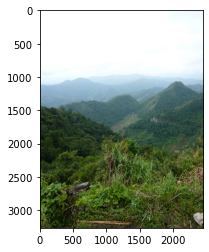

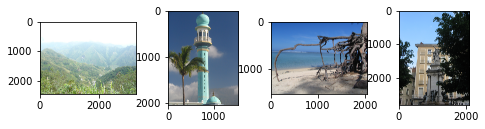

The normal ranking is 48.5 and the normalized rank is 0.455
[12.0, 77.0, 91.0, 84.0]


In [91]:
calculaRanking(fi.scores,c,0) 